In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports

In [2]:
import random
from shutil import copyfile
import os

import sys
import time

import cv2
from skimage import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### Generate Psuedo Ground Truth 

In [3]:
def euclidean_distance(a, b):
  return np.sqrt(np.sum((a - b) ** 2))

In [4]:
def get_nn_distance(p, points):
  min_dist = float('inf')

  for point in points:
    dist = euclidean_distance(p, point)
    if dist != 0:
      min_dist = min(min_dist, dist)
  
  return dist

In [5]:
def get_psuedo_boxes_from_points(points):
  bboxes = []

  for point in points:
    side = get_nn_distance(point, points)
    
    xmin = point[0] - side / 2
    xmax = point[0] + side / 2

    ymin = point[1] - side / 2
    ymax = point[1] + side / 2

    bboxes.append(np.array((xmin, ymin, xmax, ymax)))
  
  return bboxes

### Load Dataset

In [6]:
base_path = 'drive/MyDrive/AI/Dataset/Crowd Counting'
images_path = base_path + '/images'
mats_path = base_path + '/mats'

In [7]:
imgs = []

for f in os.listdir(images_path):
  f_path = images_path + '/' + f
  imgs.append(f_path)

In [8]:
img_bboxes = {}

for f in os.listdir(mats_path):
  f_path = mats_path + '/' + f
  mat = scipy.io.loadmat(f_path)

  points = mat['annPoints']
  key = f.split(".")[0]

  img = io.imread(images_path + '/' + key + '.jpg')
  height, width, _ = img.shape

  bboxes = get_psuedo_boxes_from_points(points)

  for bbox in bboxes:
    normalized_bbox = [0] * 4

    normalized_bbox[0] = bbox[0] / width
    normalized_bbox[1] = bbox[1] / height
    normalized_bbox[2] = bbox[2] / width
    normalized_bbox[3] = bbox[3] / height

    if key not in img_bboxes:
      img_bboxes[key] = []
    
    img_bboxes[key].append(normalized_bbox)

In [9]:
class_names = ['Person', 'Empty']

### Visualize Bounding Boxes

In [10]:
def draw_bounding_box(img_fname):
  img = io.imread(images_path + '/' + img_fname)

  height, width, channel = img.shape
  print(f"Image Shape: {img.shape}")

  bounding_boxes = img_bboxes[img_fname.split('.')[0]]

  for bbox in bounding_boxes:
      xmin, xmax, ymin, ymax = bbox[0], bbox[2], bbox[1], bbox[3]

      #since the coordinates are normalized
      xmin, xmax, ymin, ymax = int(xmin * width), int(xmax * width), int(ymin * height), int(ymax * height)

      class_name = class_names[0]

      print(f"Coordinates: {xmin, ymin}, {xmax, ymax}")

      cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 5)
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(img, class_name, (xmin, ymin - 10), font, 3, (0, 255, 0), 5)
      
  plt.figure(figsize=(15,10))
  plt.title('Image with Bounding Box')
  plt.imshow(img)
  plt.axis("off")
  plt.show()

### Required Dataset Format

(img_path, xmin, xmax, ymin, ymax, class_name)

train: 0.8
validation: 0.2

In [11]:
train_path = 'train_people'
test_path = 'test_people'

!mkdir train_people test_people

In [12]:
for i in range(1):
    
    all_imgs = os.listdir(images_path)
    all_imgs = [f for f in all_imgs if not f.startswith('.')]
    random.shuffle(all_imgs)
    
    limit = int(len(imgs) * 0.8)

    train_imgs = all_imgs[: limit]
    test_imgs = all_imgs[limit :]
    
    for j in range(len(train_imgs)):
        original_path = os.path.join(images_path, train_imgs[j])
        new_path = os.path.join(train_path, train_imgs[j])
        copyfile(original_path, new_path)
    
    for j in range(len(test_imgs)):
        original_path = os.path.join(images_path, test_imgs[j])
        new_path = os.path.join(test_path, test_imgs[j])
        copyfile(original_path, new_path)

In [13]:
!ls train_people | wc -l

4


In [14]:
!ls test_people | wc -l

1


In [15]:
train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Find boxes in each image and put them in a dataframe
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]

for img in train_imgs:
  key = img.split('.')[0]
  class_name = class_names[0]

  if key not in img_bboxes:
    class_name = class_names[1]
    bboxes = [[0, 0, 0, 0]]
  
  else:
    bboxes = img_bboxes[key]

  for bbox in bboxes:
    train_df = train_df.append({
        'FileName': images_path + '/' + img, 
        'XMin': bbox[0], 
        'XMax': bbox[2], 
        'YMin': bbox[1], 
        'YMax': bbox[3], 
        'ClassName': class_name}, 
        ignore_index=True)

In [16]:
train_df.sample()

,FileName,XMin,XMax,YMin,YMax,ClassName
110,drive/MyDrive/AI/Dataset/Crowd Counting/images...,0.807991,0.907418,0.609811,0.753594,Person


In [17]:
train_img_ids = train_df["FileName"].sample().str.split(".").str[0].unique()

Image Shape: (2376, 3436, 3)
Coordinates: (848, -286), (2680, 1544)
Coordinates: (2776, 1448), (3117, 1790)
Coordinates: (2417, 947), (3074, 1603)
Coordinates: (3288, 1527), (3376, 1614)
Coordinates: (1964, 1157), (2847, 2041)
Coordinates: (1773, 742), (2828, 1798)
Coordinates: (2204, 1253), (2926, 1976)
Coordinates: (1682, 1030), (2754, 2103)
Coordinates: (2930, 1427), (3180, 1677)
Coordinates: (2654, 1345), (3082, 1773)
Coordinates: (1434, 862), (2677, 2105)
Coordinates: (3122, 1489), (3256, 1622)
Coordinates: (2382, 1249), (2990, 1857)
Coordinates: (2139, 850), (2967, 1678)
Coordinates: (3083, 1261), (3346, 1524)
Coordinates: (2763, 998), (3253, 1488)
Coordinates: (1647, 884), (2754, 1990)
Coordinates: (1992, 947), (2880, 1836)
Coordinates: (2387, 1139), (3008, 1761)
Coordinates: (2460, 1163), (3034, 1737)
Coordinates: (3284, 1302), (3535, 1553)
Coordinates: (3183, 1361), (3373, 1551)
Coordinates: (3107, 1352), (3313, 1558)
Coordinates: (2996, 1361), (3234, 1600)
Coordinates: (2875,

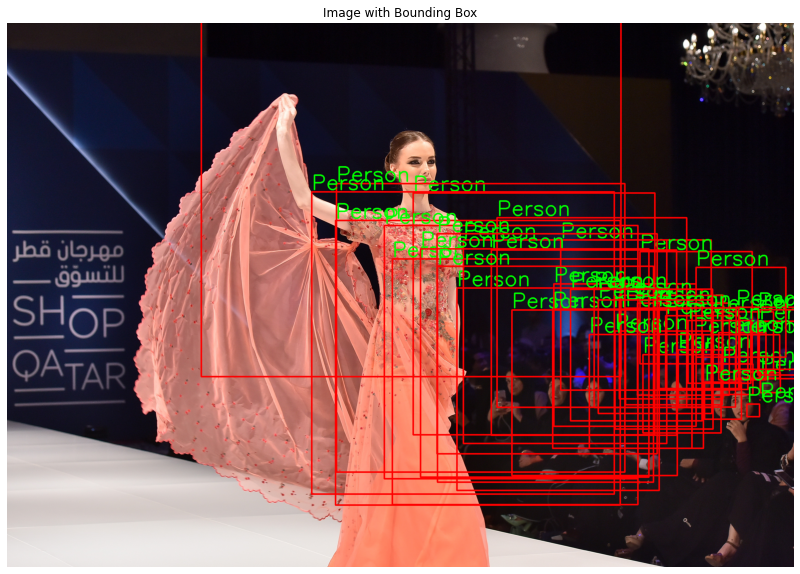

In [18]:
for img_id in train_img_ids:
  draw_bounding_box(img_id.split('/')[6] + ".jpg")

In [19]:
test_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Find boxes in each image and put them in a dataframe
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]

for img in test_imgs:
  key = img.split('.')[0]
  class_name = class_names[0]

  if key not in img_bboxes:
    class_name = class_names[1]
    bboxes = [[0, 0, 0, 0]]
  
  else:
    bboxes = img_bboxes[key]

  for bbox in bboxes:
    test_df = test_df.append({
        'FileName': images_path + '/' + img, 
        'XMin': bbox[0], 
        'XMax': bbox[2], 
        'YMin': bbox[1], 
        'YMax': bbox[3], 
        'ClassName': class_name}, 
        ignore_index=True)

In [20]:
test_df.sample()

,FileName,XMin,XMax,YMin,YMax,ClassName
0,drive/MyDrive/AI/Dataset/Crowd Counting/images...,0,0,0,0,Empty


In [21]:
train_df.to_csv('train.csv')
test_df.to_csv('test.csv')

### Write train.csv to train_annotation.txt and test.csv to test_annotation.txt

In [22]:
train_df = pd.read_csv('train.csv')

with open("train_annotation_people.txt", "w+") as f:
  for idx, row in train_df.iterrows():
      img = cv2.imread(row['FileName'])
      height, width = img.shape[: 2]
      x1, x2, y1, y2 = int(row['XMin'] * width), int(row['XMax'] * width), int(row['YMin'] * height), int(row['YMax'] * height)
      
      fileName = row['FileName']
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

In [23]:
test_df = pd.read_csv('test.csv')

with open("test_annotation_people.txt", "w+") as f:
  for idx, row in test_df.iterrows():
      img = cv2.imread(row['FileName'])
      height, width = img.shape[: 2]
      x1, x2, y1, y2 = int(row['XMin'] * width), int(row['XMax'] * width), int(row['YMin'] * height), int(row['YMax'] * height)
      
      fileName = row['FileName']
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

### Copy to the Google Drive folder

In [24]:
!mv /content/train_people /content/drive/MyDrive/AI/Dataset/Crowd\ Counting

In [25]:
!mv /content/test_people /content/drive/MyDrive/AI/Dataset/Crowd\ Counting

In [26]:
!mv /content/train_annotation_people.txt /content/drive/MyDrive/AI/Dataset/Crowd\ Counting

In [27]:
!mv /content/test_annotation_people.txt /content/drive/MyDrive/AI/Dataset/Crowd\ Counting